#Assignment:

You have been provided two files, scenario1.txt and scenario2.txt
which each contain simulated application logs in the following format:

Column 1: # seconds since time t=0

Column 2: # requests processed since last log

Column 3: Mean response time for requests processed since last log

The logging frequency is 1 per second, but there are no logs for seconds in
which there were no requests. The data span two simulated weeks and were
generated under an idealized/simplified model in which there is a single
application server which processes requests sequentially using a single thread.
If a request arrives while the server is busy, it waits in a queue until
the server is free to process it. There is no limit to the size of the queue.

For each scenario, please answer the following questions.
Note that we define "week 2" to begin at second 626400 (6 am on the 8th day).

1) How much has the mean response time (specifically, the mean of the response
times for each individual request) changed from week 1 to week 2?

2) Create a plot illustrating the probability distribution of the amount of
server time it takes to process a request (excluding the time the request
spends waiting in the queue).

3) Propose a potential cause for the change in response times. Give both a
qualitative answer as if you were explaining it to a client and a quantitative
answer as if you were explaining it to a statistician. Create 1 or 2 plots to
support and illustrate your argument.

In [2]:
import pandas as pd
import numpy as np
from numpy.random import rand
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(context='poster', style='dark')

##Scenario 2

In [3]:
df = pd.read_csv('scenario2.txt', header=None, sep='\t')
df.columns=['time', 'num_requests', 'mean_resp_time']

print('top ten entries:')
df.head(10)

top ten entries:


,time,num_requests,mean_resp_time
0,21601,5,0.069
1,21602,3,0.076
2,21606,3,0.071
3,21608,2,0.097
4,21609,1,0.045
5,21610,1,0.069
6,21611,1,0.066
7,21613,3,0.122
8,21614,1,0.088
9,21615,3,0.101


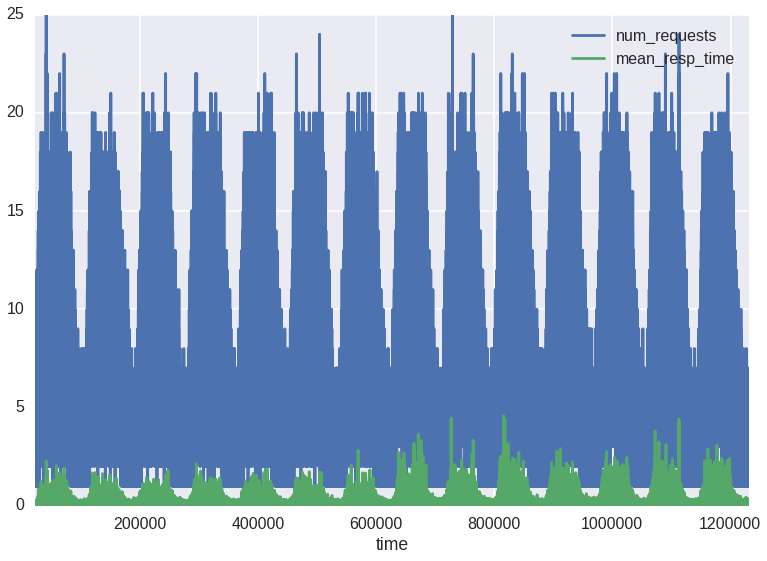

In [121]:
df.plot(x='time')

##Alright, the fun begins

Make two DataFrames for weeks 1 ('early') and 2 ('late'):

In [4]:
early_df = df.iloc[:626400]
late_df = df.iloc[626400:]

###Answer question 1:

In [5]:
print("Mean response time for Week I:", early_df.mean_resp_time.mean())
print("Mean response time for Week II:", late_df.mean_resp_time.mean())
print("Difference in %s sec" % float('%.2g' % (late_df.mean_resp_time.mean() - early_df.mean_resp_time.mean())))

Mean response time for Week I: 0.162686738506
Mean response time for Week II: 0.224895307149
Difference in 0.062 sec


### Answer questions 2 and 3:

I'll create 60-sec bins and calculate the following stats for each bin:

<b>Tr</b>: mean response time

<b>Q</b>: mean number of requests in the system

<b>λ</b>: mean request arrival rate <b>= Q / Tr</b>

Finally, <b>Ts</b> (service time) <b>= Tr / (1+Q)</b>

I'll then create arrays of each value for the total number of bins for weeks 1 and 2 ('early' and 'late', resp.).

In [6]:
def calc_stats(early_df, late_df, interval=60):
    interval = 60

    early_ix = list(range(interval, len(early_df), interval))
    late_ix = list(range(interval, len(late_df), interval))

    early_Tr = []
    late_Tr = []

    early_service_times = []
    late_service_times = []

    early_num_requests = []
    late_num_requests = []

    early_λ = []
    late_λ = []

    for i in early_ix:
        Tr = np.mean(early_df.iloc[i-interval:i].mean_resp_time)
        Q = np.mean(early_df.iloc[i-interval:i].num_requests)

        early_Tr.append(Tr)
        early_num_requests.append(Q)
        early_λ.append(Q/Tr)
        early_service_times.append(Tr/(1+Q))

    for i in late_ix:
        Tr = np.mean(late_df.iloc[i-interval:i].mean_resp_time)
        Q = np.mean(late_df.iloc[i-interval:i].num_requests)

        late_Tr.append(Tr)
        late_num_requests.append(Q)
        late_λ.append(Q/Tr)
        late_service_times.append(Tr/(1+Q))


    early_service_times = np.array(early_service_times)
    late_service_times = np.array(late_service_times)

    early_num_requests = np.array(early_num_requests)
    late_num_requests = np.array(late_num_requests)

    early_λ = np.array(early_λ)
    late_λ = np.array(late_λ)

    early_Tr = np.array(early_Tr)
    late_Tr = np.array(late_Tr)
    
    return early_service_times, late_service_times, early_num_requests, late_num_requests, early_λ, late_λ, \
            early_Tr, late_Tr
    
early_service_times, late_service_times, early_num_requests, late_num_requests, early_λ, late_λ, \
    early_Tr, late_Tr = calc_stats(early_df, late_df, interval=60)

###Sanity check (λ should correlate with number of requests):

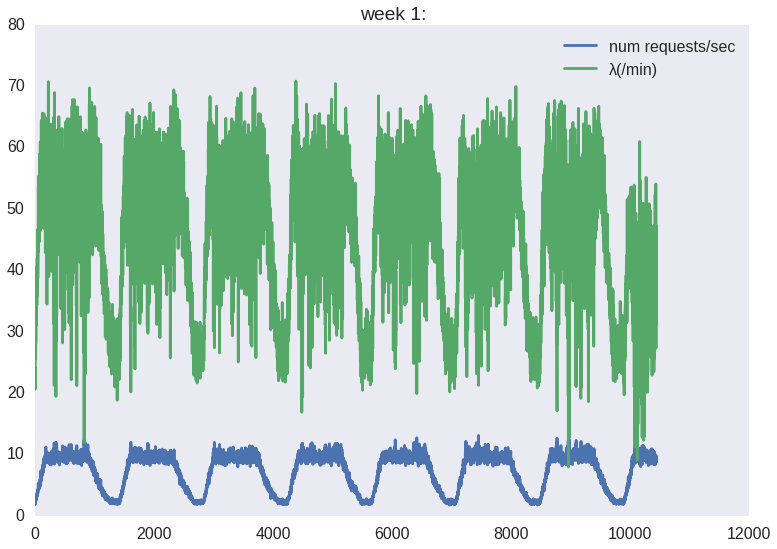

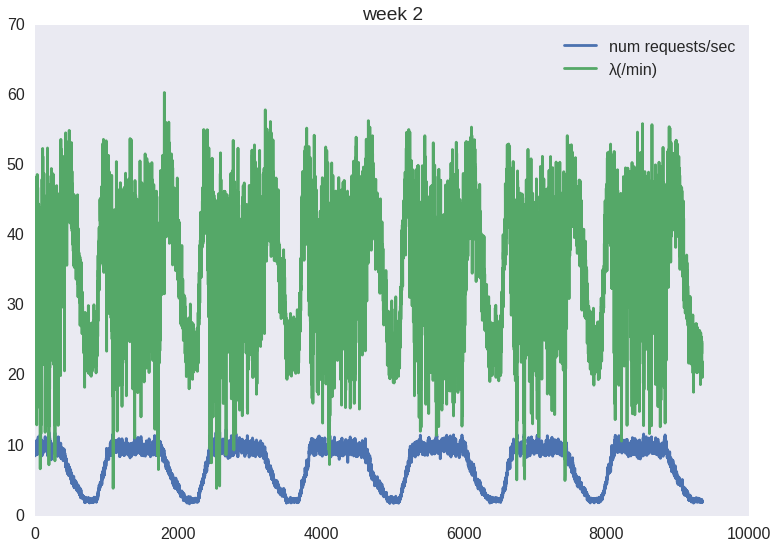

In [7]:
def plot_λ(early_num_requests, early_λ, late_num_requests, late_λ):
    plt.plot(early_num_requests, label='num requests/sec')
    plt.plot(early_λ, label='λ(/min)')
    plt.title('week 1:')
    plt.legend(loc='best')

    plt.figure()
    plt.plot(late_num_requests, label='num requests/sec')
    plt.plot(late_λ, label='λ(/min)')
    plt.title('week 2')
    plt.legend(loc='best')
    
plot_λ(early_num_requests, early_λ, late_num_requests, late_λ)

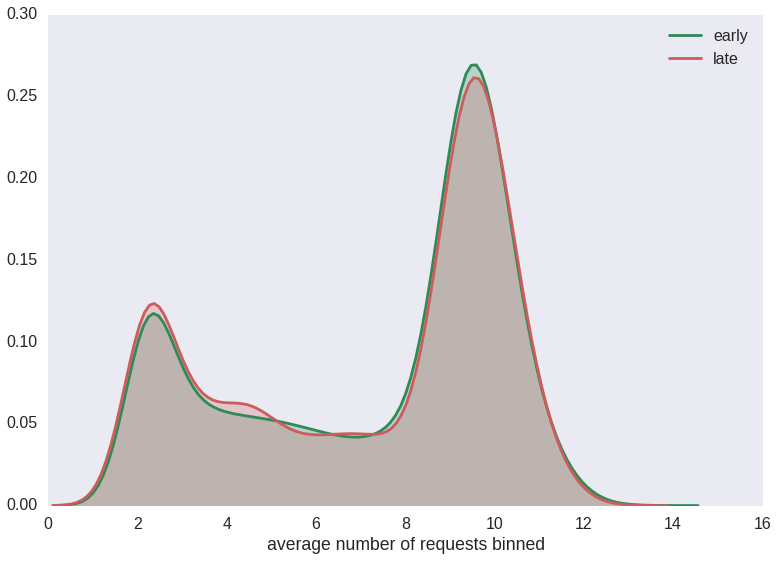

In [8]:
sns.kdeplot(early_num_requests, label='early', color='seagreen', shade=True)
sns.kdeplot(late_num_requests, label='late', color='indianred', shade=True)
plt.xlabel('average number of requests binned')

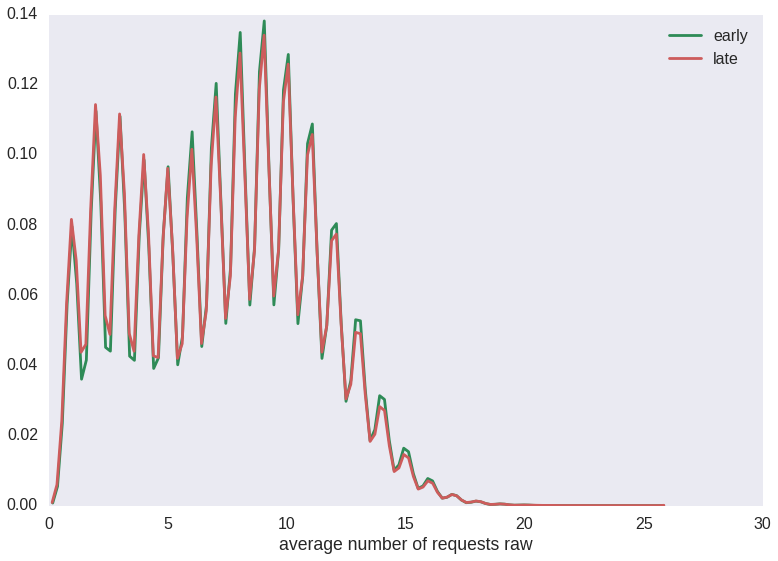

In [9]:
sns.kdeplot(early_df.num_requests, label='early', color='seagreen', shade=False)
sns.kdeplot(late_df.num_requests, label='late', color='indianred', shade=False)
plt.xlabel('average number of requests raw')

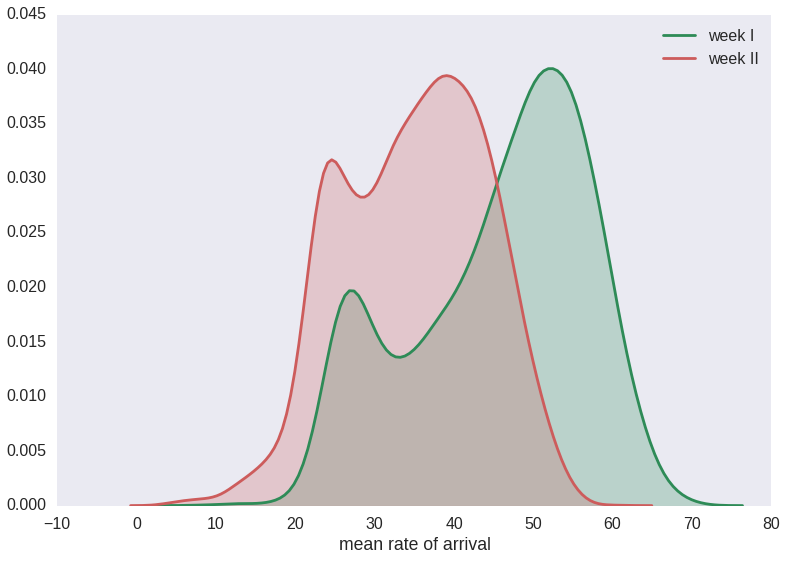

In [10]:
sns.kdeplot(early_λ, label='week I', color='seagreen', shade=True)
sns.kdeplot(late_λ, label='week II', color='indianred', shade=True)
plt.xlabel('mean rate of arrival')

###^ Despite mean rate of arrival (λ) being smaller for week II, mean response time is greater:

(-0.5, 2)

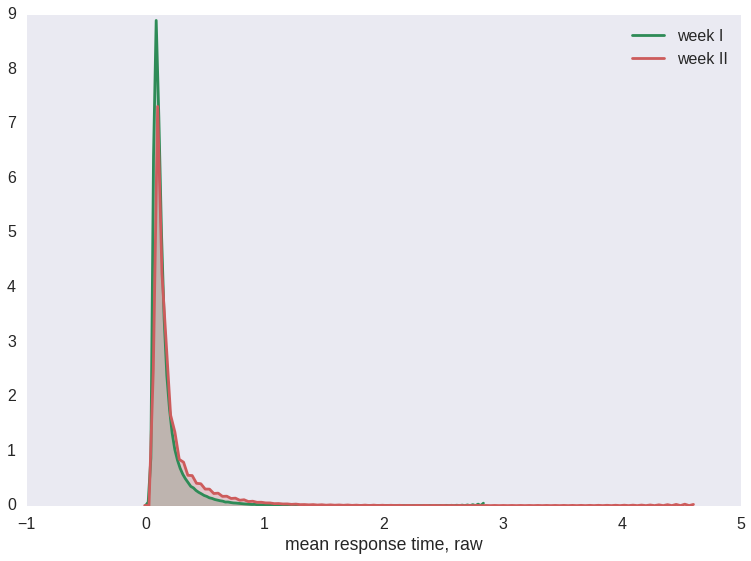

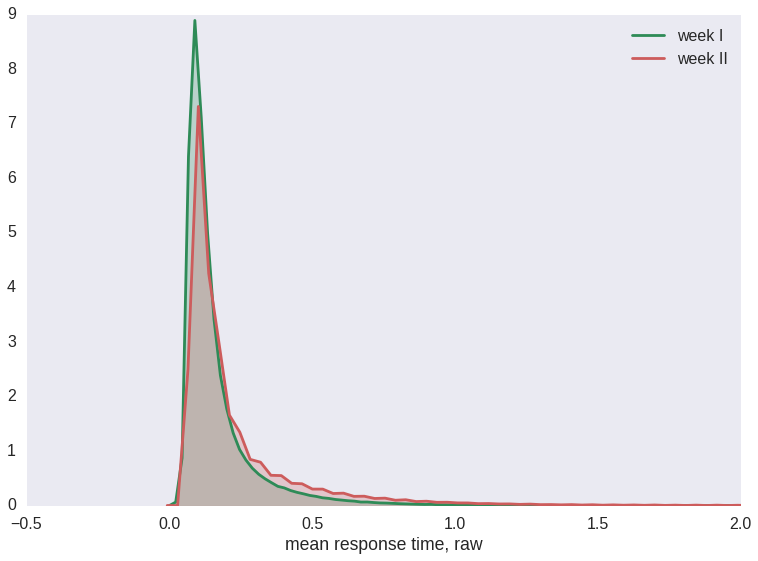

In [11]:
sns.kdeplot(early_df.mean_resp_time, label='week I', color='seagreen', shade=True)
sns.kdeplot(late_df.mean_resp_time, label='week II', color='indianred', shade=True)
plt.xlabel('mean response time, raw')

plt.figure()

sns.kdeplot(early_df.mean_resp_time, label='week I', color='seagreen', shade=True)
sns.kdeplot(late_df.mean_resp_time, label='week II', color='indianred', shade=True)
plt.xlabel('mean response time, raw')
plt.xlim([-0.5, 2])

(-0.5, 2)

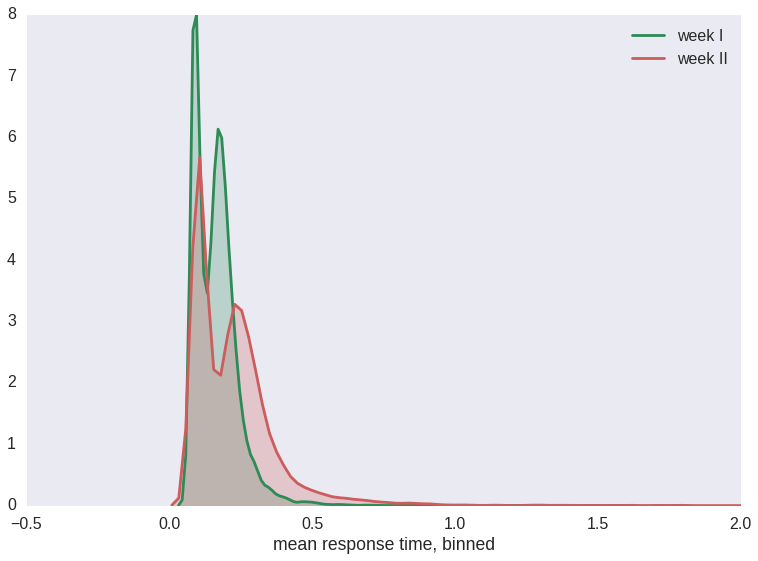

In [139]:
sns.kdeplot(early_Tr, label='week I', color='seagreen', shade=True)
sns.kdeplot(late_Tr, label='week II', color='indianred', shade=True)
plt.xlabel('mean response time, binned')
plt.xlim([-0.5, 2])

###^ Can see on both plots that response times are greater for week 2.

### Now plot average service times:

(-0.01, 0.1)

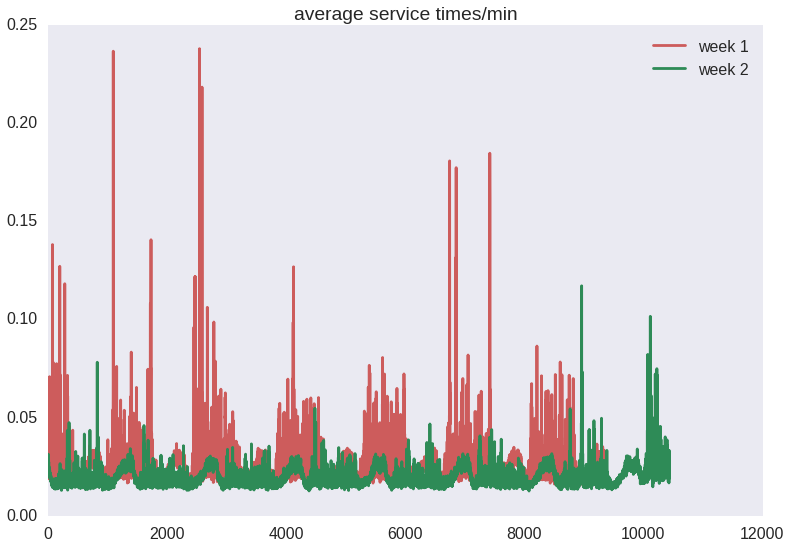

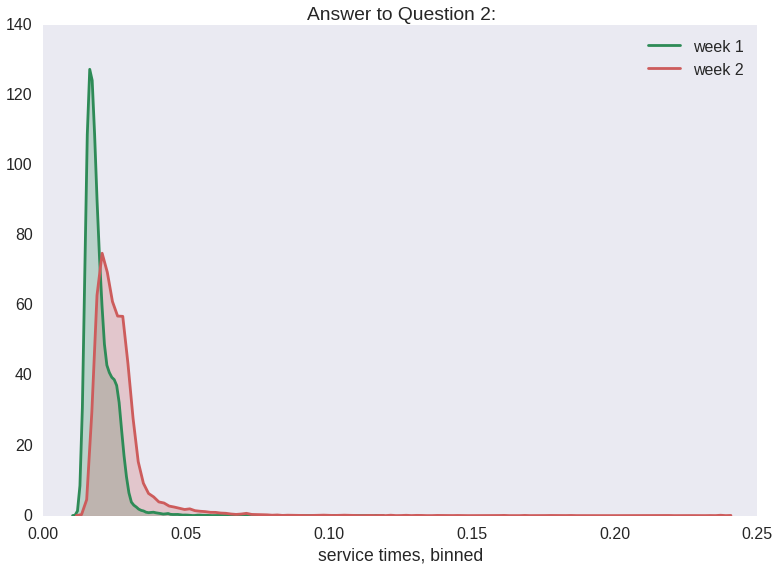

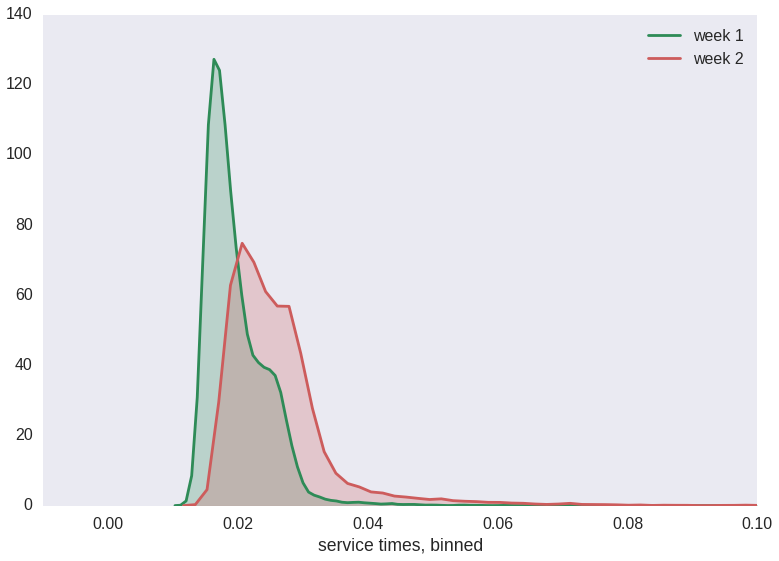

In [12]:
plt.plot(late_service_times, color='indianred', label='week 1')
plt.plot(early_service_times, color='seagreen', label='week 2')
plt.title('average service times/min')
plt.legend(loc='best')

plt.figure()

sns.kdeplot(early_service_times, label='week 1', color='seagreen', shade=True)
sns.kdeplot(late_service_times, label='week 2', color='indianred', shade=True)
plt.xlabel('service times, binned')
plt.title("Answer to Question 2:")

plt.figure()

sns.kdeplot(early_service_times, label='week 1', color='seagreen', shade=True)
sns.kdeplot(late_service_times, label='week 2', color='indianred', shade=True)
plt.xlabel('service times, binned')
plt.xlim([-0.01, 0.1])

###Answer to Question 3:
    
###During Week II, mean response time went up because arriving requests took longer to service. This can be seen by their probability distribution shifted to the right (see above).

###We see this also if we look at the mean response times in those seconds where number of requests equals 1:

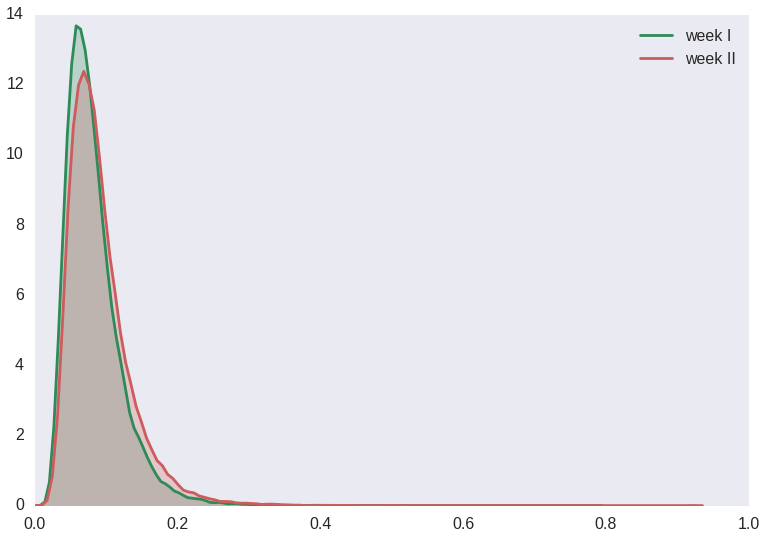

In [13]:
sns.kdeplot(early_df[early_df.num_requests==1].mean_resp_time, color='seagreen', label='week I', shade=True)
sns.kdeplot(late_df[late_df.num_requests==1].mean_resp_time, color='indianred', label='week II', shade=True)